In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import time


In [4]:
class UnivariateSpline(nn.Module):
    def __init__(self, num_knots, knot_range):
        super().__init__()
        self.num_knots = num_knots
        self.register_buffer('knots', torch.linspace(knot_range[0], knot_range[1], steps=num_knots))
        self.coeffs = nn.Parameter(torch.randn(num_knots) * 0.1)

    def forward(self, x):
        knots = self.knots
        x_clamped = torch.clamp(x, knots[0].item(), knots[-1].item())
        indices = torch.bucketize(x_clamped, knots)
        indices = torch.where(indices == self.num_knots, torch.tensor(self.num_knots - 1, device=x.device), indices)
        indices = torch.where(indices == 0, torch.tensor(1, device=x.device), indices)
        left_idx = indices - 1
        right_idx = indices
        left_knots = knots[left_idx]
        right_knots = knots[right_idx]
        left_coeffs = self.coeffs[left_idx]
        right_coeffs = self.coeffs[right_idx]
        t = (x_clamped - left_knots) / (right_knots - left_knots + 1e-6)
        return left_coeffs * (1 - t) + right_coeffs * t

In [5]:
class PsiAggregate(nn.Module):
    def __init__(self, m, input_dim=784, num_knots=10, knot_range=(0, 1)):
        super().__init__()
        self.m = m
        self.input_dim = input_dim
        self.psi_list = nn.ModuleList([UnivariateSpline(num_knots, knot_range) for _ in range(m)])
        self.weights = nn.Parameter(torch.randn(input_dim, m) * 0.1)

    def forward(self, x):
        # x: shape (batch, input_dim)
        outputs = []
        for j, psi in enumerate(self.psi_list):
            psi_out = psi(x)
            weighted = psi_out * self.weights[:, j]
            s = weighted.sum(dim=1, keepdim=True)
            outputs.append(s)
        return torch.cat(outputs, dim=1)  # shape (batch, m)

In [6]:
class PhiAggregate(nn.Module):
    def __init__(self, m, num_knots=10, knot_range=(-10, 10)):
        super().__init__()
        self.m = m
        self.phi_list = nn.ModuleList([UnivariateSpline(num_knots, knot_range) for _ in range(m)])

    def forward(self, s):
        # s: shape (batch, m)
        outputs = []
        for i, phi in enumerate(self.phi_list):
            out = phi(s[:, i])
            outputs.append(out.unsqueeze(1))
        return torch.cat(outputs, dim=1)

In [7]:
class KolmogorovArnoldNetwork(nn.Module):
    def __init__(self, m=50, psi_knots=10, phi_knots=10):
        super().__init__()
        self.psi = PsiAggregate(m, input_dim=784, num_knots=psi_knots, knot_range=(0, 1))
        self.phi = PhiAggregate(m, num_knots=phi_knots, knot_range=(-10, 10))
        self.fc = nn.Linear(m, 10)

    def forward(self, x):
        # Flatten input (batch, 1, 28, 28) to (batch, 784)
        x = x.view(x.size(0), -1)
        s = self.psi(x)
        h = self.phi(s)
        logits = self.fc(h)
        return logits

In [8]:
batch_size = 128
epochs = 10
lr = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data loading
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader   = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize model, loss, optimizer
model = KolmogorovArnoldNetwork(m=50, psi_knots=10, phi_knots=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Training
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    start_time = time.time()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader)
    elapsed = time.time() - start_time
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Time: {elapsed:.2f}s")

Epoch 1/10, Loss: 1.0413, Time: 187.95s
Epoch 2/10, Loss: 0.2604, Time: 187.35s
Epoch 3/10, Loss: 0.1830, Time: 185.11s
Epoch 4/10, Loss: 0.1426, Time: 186.95s
Epoch 5/10, Loss: 0.1185, Time: 185.94s
Epoch 6/10, Loss: 0.0997, Time: 190.82s
Epoch 7/10, Loss: 0.0857, Time: 194.53s
Epoch 8/10, Loss: 0.0754, Time: 196.91s
Epoch 9/10, Loss: 0.0660, Time: 197.10s
Epoch 10/10, Loss: 0.0578, Time: 185.37s


In [9]:
# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
test_accuracy = 100.0 * correct / total
print(f"\nTest Accuracy: {test_accuracy:.2f}%")



Test Accuracy: 96.92%


# Quantum KAN Architecture Ideas:

*   Input Encoding: We will encode the flattened pixel values of each image as quantum state. We can use ways such as angle encoding or amplitude encoding.
*   Quantum Inner Layer: For each hidden unit, we will need a parameterized quantum circuit. Each PQC takes the encoded quantum state as input, then applies rotation gates with trainable angles and entangling gates, as the phi function. In the end, we will measure certain observables.
*   Quantum outer layer: We encode the output from inner layer as input through state preparation to this new PQC. Or we can connect this two steps as one circuit for each hidden layer. We also apply rotation gates with trainable angles and entangling gates to this PQC. We then measure certain obersavable, obtaining real-value feature for each hidden unit.
*   Final classification: We can use completly classical post processing, such as a linear layer to produce logits for classification. Alternatively, we could use a quantum circuit to add non-linearity then do classical post processing.







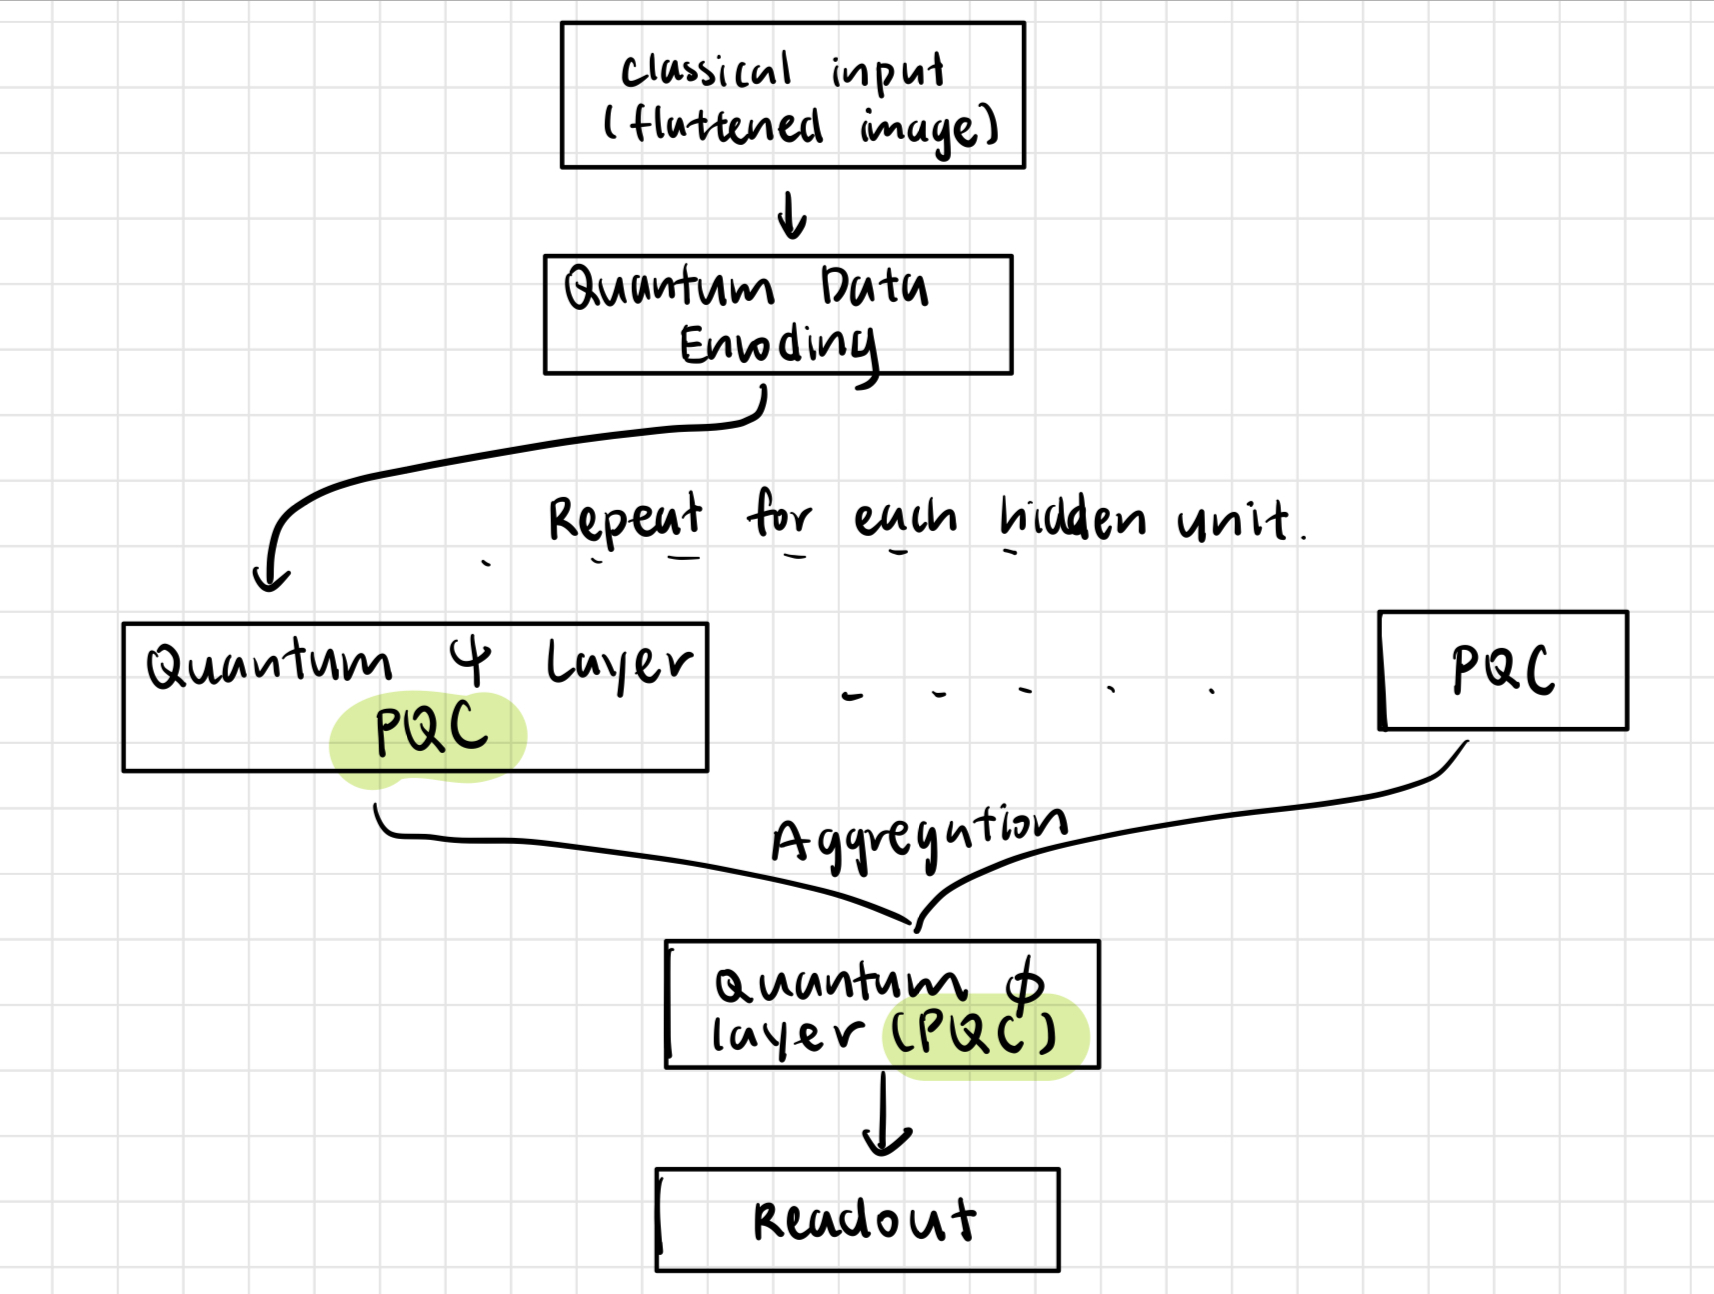